# Assignment 3: Diabetes

In this assignment, we practise constructing a naïve Bayes classifier from scratch, and then use sklearn to do the same. We will apply the classifier on a dataset of [Diabetes health indicators](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset), questionnaire results about people's health, against whether the people have been diagnosed with [diabetes](https://en.wikipedia.org/wiki/Diabetes) (or are considered prediabetic).

## Research consent
We would like to use your answers for research purposes. We are conducting a master thesis where automatic grading of plots is investigated. During this course, the plots will be graded manually. However, we would like to use as many submissions as possible for evaluating the AI-based automatic grader that is being developed as part of the master thesis.

Your submissions will be exported in bulk from CodeGrade and the **Python code** is extracted from the notebooks. All textual answers are removed and the code snippets are anonymized in such a way that it will not be possible to link them back to individual students. The data will not be made public and will only be accessed by the master thesis workers and their supervisor (the examiner of this course).

Please set the variable `RESEARCH_CONSENT` to be either `True` or `False`, depending if you agree to participate in the research or not, respectively. That is, if you set the variable `True`, your data will be used for research. If you set the variable `False`, your submission will be removed from the dataset.

The autograder will not give you a grade unless you set the variable either `True` or `False`.

In [4]:
# Codegrade Tag ResearchConsent
# Do *not* remove the tag above
# Redefine the variable below to False if you do not want to participate in research
RESEARCH_CONSENT = False

## Question 1: Read the dataset

The dataset is provided as a file called `diabetes_binary_5050split_health_indicators_BRFSS2015.csv` (available on Canvas). The first column of the dataset contains a binary indicator for whether the patient has been diagnosed with diabetes. The positive class (1) means the patient is diabetic; the negative class (0) means the patient is healthy.  The dataset has exactly 50% positive (diabetic) and 50% negative (healthy) cases.

In the first part of this assignment, we will constrain ourselves to only deal with binary class labels and binary features. That is, we only choose columns that have 0/1 values and ignore others. 

Read the entire dataset into a Pandas dataframe callled `df`.

Save the name of the target variable (the name of the column containing the class label) in a variable called `binary_target`.

Save the names of the columns that contain only 0/1 values as a list of strings in a variable called `binary_features`. Note that the target should **not** be included among the features as it would make little sense to use something to predicts itself.

Then, create two NumPy `ndarray`s called `X` and `y`. `y` should be 1-dimensional vector of length $n$ ($n$ denotes the number of rows in `df`) that contains the class label of each sample. `X` should be an `n\times d` array (where $d$ denotes the number of binary features), containing the selected features for all samples.

In [1]:
# Codegrade Tag Question1
# Do *not* remove the tag above

import pandas as pd
import numpy as np

# Load dataset into dataframe
file_path = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
df = pd.read_csv(file_path)

# Save the target variable name (the first column)
binary_target = df.columns[0]

# Identify binary features (0/1 values only), excluding the target
binary_features = [
    col for col in df.columns if col != binary_target and set(df[col].unique()).issubset({0, 1})
]

# Create numpy arrays
y = df[binary_target].values  # 1D vector
X = df[binary_features].values  # n x d matrix

## Question 2

Implement the following function `train_test_split_manual`. The function takes two mandatory positional parameters `X` and `y` which correspond to the observations and class labels. As before, `X` is assumed to have shape $n\times d$ and `y` shape `n`. The function shall perform a random train-test split, just like its sklearn counterpart `sklearn.model_selection.train_test_split`:
- The returned value shall be a 4-tuple of `ndarray`s `X_train`, `X_test`, `y_train`, `y_test`, that is, the first two arrays are the train-test split of `X` and the last two arrays the train-test split of `y`.
- `X_train` and `y_train` shall have `train_size`$\cdot n$ rows, and `X_test` and `y_test` shall have (1-`train_size`)$\cdot n$ rows.
- Each row of `X` (and `y`) shall be contained in either `X_train` (`y_train`) or `X_test` (`y_test`).
- No row shall be contained in both train and test set.
- The same split shall be always performed when `random_state` is a fixed integer (not `None`); that is, setting `random_state=1234` shall always yield the same split (but a different split will be performed if `random_state=1235`).
- If `random_state` is `None` then a random split is performed that is generally different from time to time.

Select your favorite integer as the random state and perform a split on `X` and `y`, such that 75% of the data is used for training. Store your split datasets as `X_train`, `X_test`, `y_train`, `y_test`.

**Note.** You are not allowed to use sklearn in this question. Make sure you do not import sklearn or any of its submodules within this cell or any previous cells.

**Hints:**
- A good strategy would be to construct the array $[0,1,...,n-1]$, shuffle it randomly, and then select the first `train_size`$\cdot n$ indices to serve as the training set, and the remaining as the test set.
- `np.random.default_rng` is useful and can be seeded accordingly. It even has the nice `shuffle()` method.

In [2]:
# Codegrade Tag Question2
# Do *not* remove the tag above

def train_test_split_manual(X, y, train_size = 0.75, random_state = None):
    try:
        n = X.shape[0]
        indices = np.arange(n)
    
        rng = np.random.default_rng(seed=random_state)
        rng.shuffle(indices)
    
        train_count = int(train_size * n)
        train_indices = indices[:train_count]
        test_indices = indices[train_count:]
    
        X_train = X[train_indices]
        y_train = y[train_indices]
        X_test = X[test_indices]
        y_test = y[test_indices]
    
        return X_train, X_test, y_train, y_test

    except:
        assert X.ndim == 2 and y.ndim == 1 and X.shape[0] == y.shape[0]
        raise NotImplementedError

X_train, X_test, y_train, y_test = train_test_split_manual(X, y)

## Question 3

We shall now manually implement a Naïve Bayes classifier that works on binary data, for binary classification. The classifier should look and act just like `sklearn.naive_bayes.CategoricalNB`, but you may exploit the fact that all data is supposed to be binary.

We will construct the classifier over the next few questions. You should write all answers by filling in the implementation of the class in the cell for Question 3, the upcoming questions will just evaluate more aspects of the classifier class.

For this question, implement the `fit` function such that we construct the prior. Let us assume that $X$ and $y$ have the shapes $n\times d$ and $n$, respectively. That is, we have $d$ features on $n$ observations, and a binary class label for each observation. Using [Iverson bracket notation](https://en.wikipedia.org/wiki/Iverson_bracket), let $n_0=\sum_{i=0}^{n-1} [y_i=0]$ and $n_1=\sum_{i=0}^{n-1} [y_i=1]$ be the class counts (how many 0 and 1 instances we had). Naturally, $n=n_0+n_1$. The empirical prior for classes is simply the fraction of observations belonging to that class, that is, $P(y=i) = \frac{n_i}{n}$.

The following member variables are to be defined for the class in the function `fit`:
- `n_features_in_`: integer, the number of features in the dataset `X` (the number of columns $d$)
- `classes_`: array, class labels encountered in `y` (for binary data these should always be 0 and 1)
- `class_count_`: array, the number of instances of class labels ($n_0$, $n_1$)
- `class_log_prior_`: array, the *natural logarithm* of the empirical prior probability of seeing an observation of a given class, that is, the $i$th element should correspond to $\ln P(y = i)$.

The reason we use [log probabilities](https://en.wikipedia.org/wiki/Log_probability) is that probabilities are often computationally convenient to represent as their logarithm; products become sums, which is convenient, but even more importantly the logarithmic transform makes computations numerically more stable, as the logarithms of values of different orders of magnitude become more similar. This is important as it reduces the effect that rounding errors of floating-point arithmetic has.

**Note.** You are not allowed to use `sklearn` in your submission. Do not import `sklearn` or any of its submodules in the cell corresponding to this question or any preceding cells. Otherwise the grading will fail.

**Hints:**
- Although you are not supposed to use `sklearn` in your final submission, your result is expected to match that of `sklearn.naive_bayes.CategoricalNB`, so try using that for a baseline when debugging your solution; you should get the exact same results (up to rounding error).
- `X` is ignored for this question, so you may want to construct your own `y` instances for checking that the results make sense. Your class will also be evaluated against a custom instance.

In [3]:
# Codegrade Tag Question3
# Do *not* remove the tag above

class NaiveBinaryBayes:
    """
    Naive Bayes classifier for binary features and binary class labels.

    Matches the interface of sklearn.naive_bayes.CategoricalNB
    """
    
    def __init__(self, alpha = 1.0):
        """
        Construct the classifier object.

        Parameters:
        - alpha : Parameter for Laplace smoothing (how many pseudoinstances to add for each category)
        """
        self.alpha = alpha
    

    def fit(self,X,y):
        """
        Fit the dataset X with correct class labels y into the classfier.

        Defines the following member variables:
        - n_feature_in : integer, the number of features d
        - classes_ : array, class labels
        - class_count_ : array, count of classes encountered during training
        - class_log_prior_ : logarithm of empirical prior (ln (class count / n) for each class)
        - category_count_: a list of length d, one array per feature; each array is of shape 2*2 and the element at index (j,k) in the ith array corresponds to the number of observations coming from class j that have value k for the ith feature 
        - feature_log_prob_: a list of length d, one array per feature; the element corresponds to the log of matching category count divided by the class count

        Parameters:
        - X : n observations (rows) of d features (columns), all must be binary
        - y : n class labels (binary)

        Return value:
        - Returns self
        """
        assert X.ndim == 2 and y.ndim == 1 and X.shape[0] == y.shape[0]

        n, d = X.shape
        self.n_features_in_ = d
        
        # Classes (for binary: [0,1])
        self.classes_ = np.unique(y)
        
        # Count how many samples per class
        n0 = np.sum(y == 0)
        n1 = np.sum(y == 1)
        self.class_count_ = np.array([n0, n1])
        
        # Compute log priors
        self.class_log_prior_ = np.log(self.class_count_ / n)

        # Initialize lists to store counts and log probs
        self.category_count_ = []
        self.feature_log_prob_ = []

        m = 2
        
        for j in range(d):
            # Count feature occurrences for each class
            counts = np.zeros((2, m))  # shape (class, feature_value)
            for c in [0, 1]:
                X_c = X[y == c, j]
                counts[c, 0] = np.sum(X_c == 0)
                counts[c, 1] = np.sum(X_c == 1)

            # Save raw counts
            self.category_count_.append(counts)
            
            # Apply Laplace smoothing
            # smoothed = counts + self.alpha
            # smoothed /= smoothed.sum(axis=1, keepdims=True)
            smoothed = (counts + self.alpha) / (self.class_count_[:, None] + m * self.alpha)
            
            # Save log probabilities
            self.feature_log_prob_.append(np.log(smoothed))

        return self

    
    def predict_log_proba(self, X):
        """
        Given an m*d array X, returns an m*2 array of log probabilities corresponding to the
        posterior probability of the observation coming from a given class (normalized so each row sums to 1 in probability space).

        Parameters:
        - X: an m*d array of observations to predict

        Return value:
        - An m*2 array of log probabilities
        """
        assert X.ndim == 2 and X.shape[1] == self.n_features_in_
        
        m_obs, d = X.shape
        log_joint = np.zeros((m_obs, 2), dtype=float)

        for i in range(m_obs):
            # Start from log priors
            log_post = self.class_log_prior_.copy()
            
            # Add log-likelihood terms feature-wise (Naive Bayes independence assumption)
            for j in range(d):
                val = int(X[i, j])  # feature value (0 or 1)
                # add log P(x_j=val | y=c) for each class c
                log_post[0] += self.feature_log_prob_[j][0, val]
                log_post[1] += self.feature_log_prob_[j][1, val]
            log_joint[i] = log_post
        
        # Normalize to get log posterior probabilities via log-sum-exp
        # log p(c|x) = log_joint - logsumexp(log_joint)
        max_log = np.max(log_joint, axis=1, keepdims=True)
        # compute logsumexp = max + log(sum(exp(log_joint - max)))
        sum_exp = np.exp(log_joint - max_log).sum(axis=1, keepdims=True)
        logsumexp = max_log + np.log(sum_exp)
        log_post_norm = log_joint - logsumexp  # each row sums to 1 in prob space

        return log_post_norm

    
    def predict_proba(self, X):
        """
        Given an m*d array X, returns an m*2 array of probabilities corresponding to the
        posterior probability of the observation coming from a given class

        Parameters:
        - X: an m*d array of observations to predict

        Return value:
        - An m*2 array of probabilities (each row sums to 1)
        """
        log_probs = self.predict_log_proba(X)
        probs = np.exp(log_probs)
        probs /= probs.sum(axis=1, keepdims=True)    # Numerical guard to ensure exact row sums (optional)

        return probs

    
    
    def predict(self, X):
        """
        Given an m*d array X, returns an m vector of predicted class labels

        Parameters:
        - X: an m*d array of observations to predict

        Return value:
        - An m array of class labels (corresponding to the maximum probability for each observation)
        """
        probs = self.predict_proba(X) # Class label is 1 if column 1 prob > column 0 prob

        return np.argmax(probs, axis=1).astype(int)

## Question 4

Let $x$ be a $d$-dimensional vector and $y$ the corresponding class label. The likelihood of observing that the $i$th feature has value $k$, given that the observation comes from class $j$, is $P(x_i = k \mid y = j)$. Empirically, we estimate this probability across the entire $n\times d$ training dataset $X$ by $P(x_i = k \mid y = j) = \frac{\sum_{\ell = 0}^n [X_{\ell,i} = k \text{ and } y_\ell = j]}{n_j}$. That is, we compute the *fraction* of observations from the given class that satisfy that the $i$th feature has the given value.

Finish the implementation of the `fit` function for the class `NaiveBinaryBayes`. Write your solution in the same cell as in Question 3. The function should define two additional member variables:
- `category_count_`: list of length $d$, that is, one element per feature; each element should be an `ndarray` of shape $2\times 2$. In the $i$th array, the element at $(j,k)$ should correspond to the number of elements from class $j$ that have value $k$ in the $i$th feature, that is, `category_count_[2][0,1]` should be the count of elements from class 0 whose feature number 2 has value 1.
- `feature_log_prob_`: list of length $d$, just like category count, but instead of the count, `feature_log_prob_[i][j,k]` should contain the empirical log likelihood $\ln P(x_i=k\mid y=j)$.

**Note.** You are not allowed to use `sklearn` in your submission. Do not import `sklearn` or any of its submodules in the cell corresponding to this question or any preceding cells. Otherwise the grading will fail.

**Hints:**
- Although you are not supposed to use `sklearn` in your final submission, your result is expected to match that of `sklearn.naive_bayes.CategoricalNB`, so try using that for a baseline when debugging your solution; you should get the exact same results (up to rounding error).
- If you need to debug with simpler instances, try constructing your own $X$ and $y$ pairs and make sure you understand what the results should be (and why).

*There is no separate code cell for this question*

## Question 5

Implement the prediction functions `predict`, `predict_proba`, and `predict_log_proba`. Given an $m \times d$ array of observations,
- `predict_log_proba` should return an $m\times 2$ array of log probabilities corresponding to the probabilities of the classes,
- `predict_proba` should return an $m\times 2$ array of probabilities corresponding to the probabilities of the classes,
- `predict` should return an $m$-vector of predicted class labels.

You can compute log probability almost directly from the values computed in `fit`, except you will have to normalize the probabilities so that they sum to 1. That is, all rows of the array returned by `predict_proba` should sum to 1. The relationship between the values returned by the three functions are:
- `np.log` and `np.exp` can be used to transform the values between probabilities and log probabilities,
- the class label is 1 iff the probability in column 1 is greater than in column 0.

Write your answers by in the cell of Question 3.

**Note.** You are not allowed to use `sklearn` in your submission. Do not import `sklearn` or any of its submodules in the cell corresponding to this question or any preceding cells. Otherwise the grading will fail.

**Hints:**
- Although you are not supposed to use `sklearn` in your final submission, your result is expected to match that of `sklearn.naive_bayes.CategoricalNB`, so try using that for a baseline when debugging your solution; you should get the exact same results (up to rounding error).
- If you need to debug with simpler instances, try constructing your own $X$ and $y$ pairs and make sure you understand what the results should be (and why).
- Pro tip: implement `predict_log_proba` first and use it as a subroutine for implementing the other functions.
- `np.argmax` is useful for implementing `predict`.
- To normalize log probabilities, it might be easiest to just take the exponential of the values, divide by the rowwise sum, and take a logarithm.

*There is no separate code cell for this question*

## Question 6

Implement Laplace smoothing. Change the constructor in such a way that the $\alpha$ parameter is stored as a member variable `alpha` (without a trailing underscore).

Then, change fitting in such a way that, if there are $m$ distinct categories for the feature, the empirical likelihood becomes $P(x_i=k\mid y=j) = \frac{\alpha + \sum_{\ell=0}^{n-1} [X_{\ell,i}=k \text{ and } y=j]}{n_j+m\alpha}$.

Write your answers by in the cell of Question 3.

**Note.** You are not allowed to use `sklearn` in your submission. Do not import `sklearn` or any of its submodules in the cell corresponding to this question or any preceding cells. Otherwise the grading will fail.

**Hints:**
- Although you are not supposed to use `sklearn` in your final submission, your result is expected to match that of `sklearn.naive_bayes.CategoricalNB`, so try using that for a baseline when debugging your solution; you should get the exact same results (up to rounding error).
- If you need to debug with simpler instances, try constructing your own $X$ and $y$ pairs and make sure you understand what the results should be (and why).
- Since we're restricting ourselves to binary features, you can assume $m=2$.

*There is no separate code cell for this question*

## Question 7

Implement the following function that computes the confusion matrix for a binary classification task. The first parameter of the function is a vector that contains the correct class labels. The second parameter are the predicted class labels. You may assume that there are only 2 classes (0 and 1).

The output must be a $2\times 2$ matrix $C$ where $C_{ij}$ is the number of instances of class $i$ that were predicted to be in class $j$.

**Note.** You are not allowed to use `sklearn` in your submission. Do not import `sklearn` or any of its submodules in the cell corresponding to this question or any preceding cells. Otherwise the grading will fail.

**Hints:**
- Although you are not supposed to use `sklearn` in your final submission, your result is expected to match that of `sklearn.metrics.confusion_matrix`, so try using that for a baseline when debugging your solution; you should get the exact same results (up to rounding error).
- If you need to debug with simpler instances, try constructing your own `y_pred` and `y_true` pairs and make sure you understand what the results should be (and why).

In [4]:
# Codegrade Tag Question7
# Do *not* remove the tag above

def confusion_matrix_manual(y_true, y_pred):
    """
    Computes a confusion matrix for binary classification predictions.

    Parameters:
    - y_true: vector, ground truth
    - y_pred: vector, predictions

    Return value:
    - A 2*2 matrix of classification values
    """

    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    if y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("y_true and y_pred must have the same length.")

    # Ensure integer indices for advanced indexing (fixes your IndexError)
    if not np.issubdtype(y_true.dtype, np.integer):
        y_true = y_true.astype(int)
    if not np.issubdtype(y_pred.dtype, np.integer):
        y_pred = y_pred.astype(int)

    # Validate labels are binary (0/1)
    if not np.isin(y_true, [0, 1]).all() or not np.isin(y_pred, [0, 1]).all():
        raise ValueError("Labels must be binary (0 or 1).")

    C = np.zeros((2, 2), dtype=int)
    np.add.at(C, (y_true, y_pred), 1)

    return C

## Question 8

Implement the following four function that compute accuracy, precision, recall, and $F$-score, respectively. Unlike the functions in sklearn, the functions shall take the confusion matrix as input.

**Note.** You are not allowed to use `sklearn` in your submission. Do not import `sklearn` or any of its submodules in the cell corresponding to this question or any preceding cells. Otherwise the grading will fail.

**Hints:**
- Although you are not supposed to use `sklearn` in your final submission, your result is expected to match that of `sklearn.metrics` functions (with appropriate inputs), so try using that for a baseline when debugging your solution; you should get the exact same results (up to rounding error).
- If you need to debug with simpler instances, try constructing your own `y_pred` and `y_true` pairs and make sure you understand what the results should be (and why).

In [5]:
# Codegrade Tag Question8
# Do *not* remove the tag above

def accuracy_score_manual(confusion_matrix):
    """
    Given confusion matrix, computes the accuracy

    Parameters:
    - confusion_matrix: a 2*2 matrix

    Return value:
    - floating point, accuracy (fraction of correct classifications)
    """

    try:
        tp = confusion_matrix[1, 1]
        tn = confusion_matrix[0, 0]
        total = confusion_matrix.sum()
        return (tp + tn) / total if total > 0 else 0.0
    
    except:
        raise NotImplementedError
    
def precision_score_manual(confusion_matrix):
    """
    Given confusion matrix, computes the precision

    Parameters:
    - confusion_matrix: a 2*2 matrix

    Return value:
    - floating point, precision (fraction of relevant entries among positive classifications)
    """

    try:
        tp = confusion_matrix[1, 1]
        fp = confusion_matrix[0, 1]
        denom = tp + fp
        return tp / denom if denom > 0 else 0.0
    
    except:
        raise NotImplementedError

def recall_score_manual(confusion_matrix):
    """
    Given confusion matrix, computes the recall

    Parameters:
    - confusion_matrix: a 2*2 matrix

    Return value:
    - floating point, recall (fraction of relevant entries returned)
    """

    try:
        tp = confusion_matrix[1, 1]
        fn = confusion_matrix[1, 0]
        denom = tp + fn
        return tp / denom if denom > 0 else 0.0
    except:
        raise NotImplementedError
    
def f1_score_manual(confusion_matrix):
    """
    Given confusion matrix, computes the F-score

    Parameters:
    - confusion_matrix: a 2*2 matrix

    Return value:
    - floating point, F-score (harmonic mean of precision and recall)
    """

    try:
        precision = precision_score_manual(confusion_matrix)
        recall = recall_score_manual(confusion_matrix)
        denom = precision + recall
        return (2 * precision * recall) / denom if denom > 0 else 0.0
    except:
        raise NotImplementedError


In [6]:
model = NaiveBinaryBayes()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
lp_pred = model.predict_log_proba(X_test)
matrix = confusion_matrix_manual(y_test, y_pred)
acc = accuracy_score_manual(matrix)
pre = precision_score_manual(matrix)
rec = recall_score_manual(matrix)
f1 = f1_score_manual(matrix)

acc, pre, rec, f1

(np.float64(0.7084818649917954),
 np.float64(0.712808988764045),
 np.float64(0.7096196868008948),
 np.float64(0.7112107623318386))

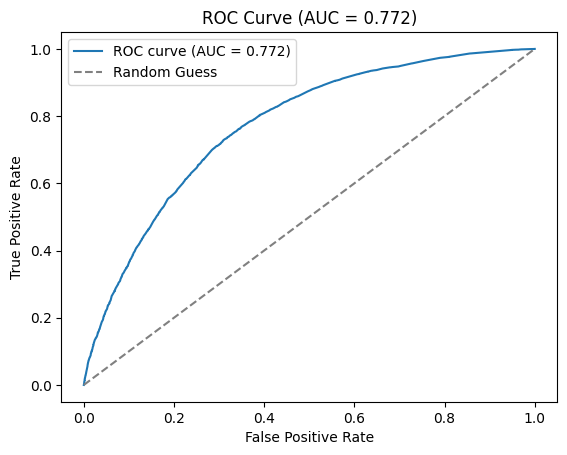

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Use log probabilities for class 1 as the score
scores = lp_pred[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, scores)

# Compute AUC
auc = roc_auc_score(y_test, scores)

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:0.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC Curve (AUC = {auc:0.3f})")
ax.legend()

plt.show()

## Question 9

Try out how the classification results look like in light of the metrics (accuracy, precision, recall, F-score). How well does your model work? Does the choice of the parameter $\alpha$ make a difference? Why/why not? Does your model work better than a *monkey classifier*, that is, one where the class is determined by a flip of a coin? How about a dummy classifier that always assigns the most likely class label?

Write 1–3 paragraphs.

*Write your answer here*

Overall, we can see the values of four metrics between 0.73 ~ 0.7. The accuracy is 0.708, the precision is 0.719, the recall is 0.710 and the f1-score is 0.711. The outcome is still acceptalbe since the values achives 70%. However, the result may be improved by random state in dataset train_split process.

The smoothing parameter α mainly matters when counts are small or some feature–class combinations are rare. If α is set extremely high, it pushes conditional probabilities toward uniform, shrinking the model toward the prior and hurting recall/precision. If α is too small, you risk overfitting and brittle predictions due to zeros.

The NaiveBinaryBayes model should beat the monkey (coin-flip) as long as the features carry any signal about the label. A fair coin averages 50% accuracy and wildly unstable precision/recall. A dummy achieves accuracy equal to the class prior but typically has poor recall for the minority class and thus an F1 near 0 for that class. 

## Question 10

From here on, you are free to use `sklearn`.

Construct a new train/test split using `sklearn.model_selection.train_test_split` with random state 16445, with 75% of the data used for training, using *all* features (except `Diabetes_binary`) for `X`. Store the dataset in variables `X_train`, `X_test`, `y_train`, `y_test`, respectively.

Then, use `sklearn.naive_bayes.CategoricalNB` with `alpha=1` and fit the training data. Then, predict the class labels for the test data and store your predictions in a variable called `y_pred`. Also store the predicted log probabilities in `lp_pred`.

Compute the accuracy, precision, recall, and F-score of your classifier and store them in variables called `accuracy`, `precision`, `recall`, `fscore`, respectively.

In [8]:
# Codegrade Tag Question10
# Do *not* remove the tag above

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Separate features and target
y = df["Diabetes_binary"].values
X = df.drop(columns=["Diabetes_binary"]).values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=16445)

# Train Naive Bayes classifier
clf = CategoricalNB(alpha=1)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
lp_pred = clf.predict_log_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred)

accuracy, precision, recall, fscore

(0.7390369490182764,
 0.7436374201045903,
 0.7267461669505962,
 0.7350947731188971)

## Question 11

Finally, compute the Receiver-Operator Characteristic. As before, create the axes using `plt.subplots()` and store the axis object as `ax`. In your plot, include the Area Under Curve (AUC), with 3 decimal digits of precision, in the title of your plot. Remember to label your axes.

**Hints.**
- Use `sklearn.metrics.roc_curve` to obtain the FPR and TPR values to plot.
- The log probabilities can be used as the score to compute the FPR and TPR.
- You can directly compute AUC with `sklearn.metrics.roc_auc_score`.
- The format specifier `f'{x:0.3f}'` formats a floating-point number with 3 decimal digits of precision. 

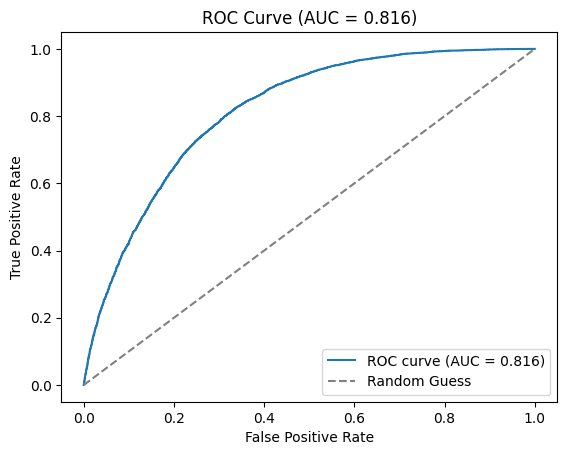

In [9]:
# Codegrade Tag Question11
# Do *not* remove the tag above

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Use log probabilities for class 1 as the score
scores = lp_pred[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, scores)

# Compute AUC
auc = roc_auc_score(y_test, scores)

# Plot ROC curve
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:0.3f})")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC Curve (AUC = {auc:0.3f})")
ax.legend()

plt.show()